
##Import Libraries




In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import random_split

import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid

##Load Dataset

In [ ]:
data_path_train = "/content/drive/MyDrive/covid_X-ray_data/train"
data_path_test = "/content/drive/MyDrive/covid_X-ray_data/test"

In [ ]:
img_size = 120

img_transform = transforms.Compose([transforms.Resize((img_size, img_size)),
                                    transforms.RandomHorizontalFlip(),
                                    transforms.ToTensor(),  
                                    transforms.Normalize(mean=[0.485,0.456,0.406],std=[0.229,0.224,0.225])])

##ImageFolder & DataLoader
The dataset that we are using has the images sorted and labeled in 3 different folders. ie, Covid, Normal and Viral Pneumonia. To make our training and testing dataset from these organized folders, we use ImageFolder that we have imported earlier.

In [ ]:
train_data = ImageFolder(root = data_path_train, transform=img_transform )

test_data = ImageFolder(root = data_path_test, transform=img_transform)

In [ ]:
len(train_data), len(test_data)

(251, 66)

In [ ]:
train_data.class_to_idx

{'Covid': 0, 'Normal': 1, 'Viral Pneumonia': 2}

Let us split our testing data into two datasets using random_split. One is for testing and the other is for validation.



In [ ]:
val_data, test_data = random_split(test_data,[50,16])

Now we use DataLoader to turn our dataset into batches so that our model will not be overburdened. Since our dataset is small, we divide our data into batches of 16.

In [ ]:
train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
val_loader = DataLoader(val_data, batch_size=16, shuffle=False)

Let us now check the shape of our images and labels

In [ ]:
for img, labels in train_loader:
  print(img.shape)
  break

torch.Size([16, 3, 120, 120])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


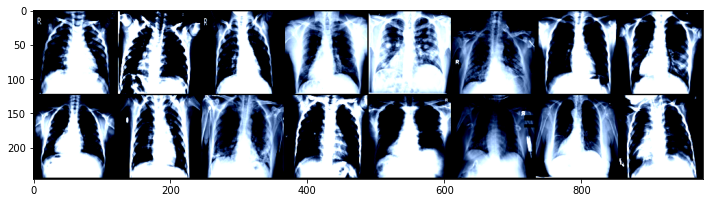

In [ ]:
def show_img(data):
  for img, label in data:
    plt.figure(figsize = (12,6))
    plt.imshow(make_grid(img, n_rows= 5).permute(1,2,0))
    plt.show()
    break
show_img(train_loader)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


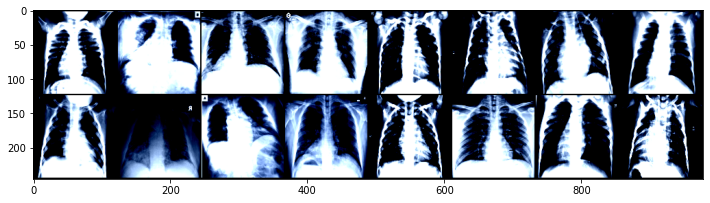

In [ ]:
show_img(val_loader)

##Creating Model
Let us now create a class function for our ANN model

In [ ]:
class ANN(nn.Module):
  def __init__(self, hidden_layer = 64):
    super(ANN, self).__init__()

    self.fc1 = nn.Linear(120*120*3, hidden_layer)
    self.fc2 = nn.Linear(hidden_layer,3)

    self.relu = nn.ReLU()

  def forward(self, img):

    out = img.view(-1, 120*120*3)
    out = self.fc1(out)
    out = self.relu(out)
    out = self.fc2(out)

    return out

In [ ]:
model = ANN()
print(model)

ANN(
  (fc1): Linear(in_features=43200, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=3, bias=True)
  (relu): ReLU()
)


Define the Loss function and Optimizer for our model. Here we are using Cross-Entropy Loss and SGD.

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD( model.parameters(), lr= 0.001)


##Training the Model
Lets us now create a function to train our model.

In [ ]:
def train(model, loss_fn, optimizer):
  epochs = 15
  training_loss = []
  training_acc = []
  validation_loss = []
  validation_acc = []

  for epoch in range(epochs):
    train_loss = 0.0
    train_acc = 0.0

    model.train()

    for images, labels in train_loader:

      optimizer.zero_grad()
      output = model(images)
      loss = loss_fn(output, labels)

      loss.backward()
      optimizer.step()

      predictions = torch.argmax(output, 1)
      train_acc += (predictions==labels).sum().item()
      train_loss += loss.item()

    training_acc.append(train_acc/len(train_data))
    training_loss.append(train_loss/len(train_loader))

    
    val_loss = 0.0
    val_acc = 0.0

    with torch.no_grad():
      for images, labels in val_loader:

        output = model(images)
        loss = loss_fn(output, labels)

        predictions = torch.argmax(output, 1)

        val_acc += (predictions==labels).sum().item()
        val_loss += loss.item()

      validation_acc.append(val_acc/len(val_data))
      validation_loss.append(val_loss/len(val_loader))

      print("Epochs:{}, Training Accuracy:{:.2f}, Training Loss:{:.2f}, Validation Accuracy:{:2f}, Validation Loss:{:.2f}".format(
            epoch+1,train_acc/len(train_data),train_loss/len(train_loader),val_acc/len(val_data),val_loss/len(val_loader)))

  plt.title("Accuracy Vs Epochs")
  plt.plot(range(epochs), training_acc, label ="Training Accuracy")
  plt.plot(range(epochs), validation_acc, label = "Validation Accuracy")
  plt.legend()
  plt.xlabel("Accuracy")
  plt.ylabel("Epochs")
  plt.show()


  plt.title("Loss Vs Epochs")
  plt.plot(range(epochs), training_loss, label ="Training Loss")
  plt.plot(range(epochs), validation_loss, label = "Validation Loss")
  plt.legend()
  plt.xlabel("Accuracy")
  plt.ylabel("Epochs")
  plt.show()


Epochs:1, Training Accuracy:0.76, Training Loss:0.58, Validation Accuracy:0.740000, Validation Loss:0.54
Epochs:2, Training Accuracy:0.87, Training Loss:0.36, Validation Accuracy:0.820000, Validation Loss:0.40
Epochs:3, Training Accuracy:0.91, Training Loss:0.26, Validation Accuracy:0.860000, Validation Loss:0.39
Epochs:4, Training Accuracy:0.91, Training Loss:0.25, Validation Accuracy:0.680000, Validation Loss:0.76
Epochs:5, Training Accuracy:0.90, Training Loss:0.23, Validation Accuracy:0.880000, Validation Loss:0.36
Epochs:6, Training Accuracy:0.93, Training Loss:0.20, Validation Accuracy:0.820000, Validation Loss:0.41
Epochs:7, Training Accuracy:0.92, Training Loss:0.18, Validation Accuracy:0.880000, Validation Loss:0.30
Epochs:8, Training Accuracy:0.94, Training Loss:0.17, Validation Accuracy:0.880000, Validation Loss:0.30
Epochs:9, Training Accuracy:0.97, Training Loss:0.14, Validation Accuracy:0.840000, Validation Loss:0.34
Epochs:10, Training Accuracy:0.96, Training Loss:0.15, 

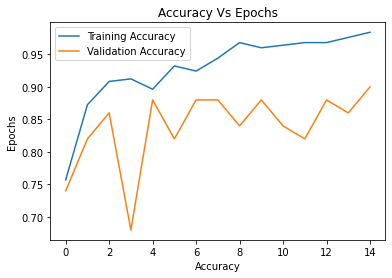

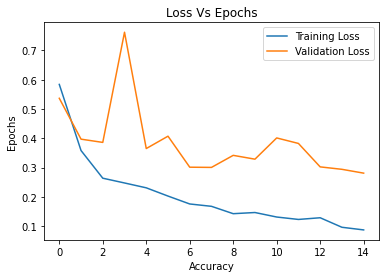

In [ ]:
train(model,loss_fn, optimizer)


##Visualizing the results on Real World Covid X-RAYImage
To visualize our model’s predictions, we need to create a function that can read our image and return the predicted label

In [ ]:
def predict_img(img, model):
  x = img.unsqueeze(0)
  y = model(x)

  pred = torch.argmax(y, dim= 1)
  return train_data.classes[pred]
  


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Actual Label: Covid Predicted Label: Covid


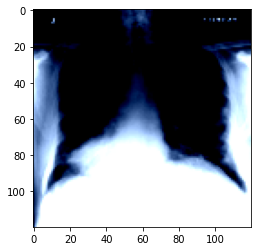

In [ ]:
img , label = test_data[2]
plt.imshow(img.permute(1,2,0))
print("Actual Label:", train_data.classes[label], "Predicted Label:", predict_img(img, model))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Actual Label: Normal Predicted Label: Normal


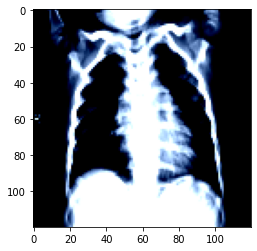

In [ ]:
img , label = test_data[10]
plt.imshow(img.permute(1,2,0))
print("Actual Label:", train_data.classes[label], "Predicted Label:", predict_img(img, model))